In [8]:
%%capture
!pip install datasets
!pip install certifi

In [1]:
!pip install seaborn

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

### Get SQL queries

In [28]:
import os
import os.path
import ssl
import stat
import subprocess
import sys

STAT_0o775 = ( stat.S_IRUSR | stat.S_IWUSR | stat.S_IXUSR
             | stat.S_IRGRP | stat.S_IWGRP | stat.S_IXGRP
             | stat.S_IROTH |                stat.S_IXOTH )


def main():
    openssl_dir, openssl_cafile = os.path.split(
        ssl.get_default_verify_paths().openssl_cafile)

    print(" -- pip install --upgrade certifi")
    subprocess.check_call([sys.executable,
        "-E", "-s", "-m", "pip", "install", "--upgrade", "certifi"])

    import certifi

    # change working directory to the default SSL directory
    os.chdir(openssl_dir)
    relpath_to_certifi_cafile = os.path.relpath(certifi.where())
    print(" -- removing any existing file or link")
    try:
        os.remove(openssl_cafile)
    except FileNotFoundError:
        pass
    print(" -- creating symlink to certifi certificate bundle")
    os.symlink(relpath_to_certifi_cafile, openssl_cafile)
    print(" -- setting permissions")
    os.chmod(openssl_cafile, STAT_0o775)
    print(" -- update complete")

main()


# os.environ['REQUESTS_CA_BUNDLE'] = '/Users/ESMoraEn/repositories/DigiCert TLS Hybrid ECC SHA384 2020 CA1.cer'

 -- pip install --upgrade certifi
 -- removing any existing file or link
 -- creating symlink to certifi certificate bundle
 -- setting permissions
 -- update complete


In [24]:
import ssl 
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
from datasets import load_dataset

sql = load_dataset('wikisql', split='test')

/anaconda/envs/oppe4rl_22/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset wikisql (/home/azureuser/.cache/huggingface/datasets/wikisql/default/0.1.0/7037bfe6a42b1ca2b6ac3ccacba5253b1825d31379e9cc626fc79a620977252d)


In [5]:
sql['sql']

[{'human_readable': 'SELECT Nationality FROM table WHERE Player = Terrence Ross',
  'sel': 2,
  'agg': 0,
  'conds': {'column_index': [0],
   'operator_index': [0],
   'condition': ['Terrence Ross']}},
 {'human_readable': 'SELECT School/Club Team FROM table WHERE Years in Toronto = 1995-96',
  'sel': 5,
  'agg': 0,
  'conds': {'column_index': [4],
   'operator_index': [0],
   'condition': ['1995-96']}},
 {'human_readable': 'SELECT School/Club Team FROM table WHERE Years in Toronto = 2003-06',
  'sel': 5,
  'agg': 0,
  'conds': {'column_index': [4],
   'operator_index': [0],
   'condition': ['2003-06']}},
 {'human_readable': 'SELECT COUNT School/Club Team FROM table WHERE Player = Jalen Rose',
  'sel': 5,
  'agg': 3,
  'conds': {'column_index': [0],
   'operator_index': [0],
   'condition': ['Jalen Rose']}},
 {'human_readable': 'SELECT Round FROM table WHERE Circuit = Assen',
  'sel': 2,
  'agg': 0,
  'conds': {'column_index': [3],
   'operator_index': [0],
   'condition': ['Assen']}},


In [6]:
sql = sql['sql'][:1000]
sql = [x['human_readable'] for x in sql]
print(sql[:10])
print(len(sql))

['SELECT Nationality FROM table WHERE Player = Terrence Ross', 'SELECT School/Club Team FROM table WHERE Years in Toronto = 1995-96', 'SELECT School/Club Team FROM table WHERE Years in Toronto = 2003-06', 'SELECT COUNT School/Club Team FROM table WHERE Player = Jalen Rose', 'SELECT Round FROM table WHERE Circuit = Assen', 'SELECT COUNT No FROM table WHERE Pole Position = Kevin Curtain', 'SELECT Date FROM table WHERE Circuit = Misano', 'SELECT COUNT Position FROM table WHERE College/junior/club team = Sherbrooke Faucons (QMJHL)', 'SELECT Nationality FROM table WHERE College/junior/club team = Thunder Bay Flyers (USHL)', 'SELECT COUNT College/junior/club team FROM table WHERE NHL team = Washington Capitals']
1000


In [7]:
train_sql = sql.copy()

In [8]:
import pandas as pd

test_df = pd.DataFrame({'sql_sentence': train_sql})
test_df.to_csv('test_df.csv', index=False)

In [9]:
pd.read_csv('test_df.csv').shape

(1000, 1)

### Get sentences

In [10]:
sentences = load_dataset('glue', 'stsb', split='test')
print(sentences.shape)

Dataset glue downloaded and prepared to /home/azureuser/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.
(1379, 4)


In [11]:
sentences = sentences.shuffle(seed=1113)['sentence1'][:1000]
print(sentences[:10])

['Storm buries Northeast; 16 inches of snow in NJ', "You don't have to know.", 'A girl is playing guitar.', "I don't think it makes any tremendous difference.", 'Militant attack from Afghanistan kills four in Upper Dir', 'The New York senator\'s new book, "Living History," appears a certain bestseller.', "I think it's fine to ask this question.", 'Schiphol airport partly evacuated after bomb threat', 'Syria fighting rages as Russia urges Western re-think', 'Nigeria mourns over 193 people killed in plane crash']


### Generate dataset

In [12]:
import pandas as pd 
import numpy as np

data = pd.DataFrame({'sentence': sql+sentences, 'is_sql': np.concatenate((np.ones(1000), np.zeros(1000)))})
data.shape

(2000, 2)

In [13]:
data.iloc[995:1005]

,sentence,is_sql
995,SELECT COUNT Area (km²) FROM table WHERE Popul...,1.0
996,SELECT 3’UTR sequence FROM table WHERE GenBank...,1.0
997,SELECT Coding FROM table WHERE GenBank id = HQ...,1.0
998,SELECT 3’UTR sequence FROM table WHERE Variant...,1.0
999,SELECT 3’UTR sequence FROM table WHERE Variant...,1.0
1000,Storm buries Northeast; 16 inches of snow in NJ,0.0
1001,You don't have to know.,0.0
1002,A girl is playing guitar.,0.0
1003,I don't think it makes any tremendous difference.,0.0
1004,Militant attack from Afghanistan kills four in...,0.0


### Get embeddings

In [14]:
%%capture 
!pip install transformers

In [15]:
from transformers import RobertaTokenizer, RobertaModel
  
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

2023-06-15 11:43:46.276927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSeq

In [16]:
tokenizer.save_pretrained('.')
model.save_pretrained('.')

In [17]:
%%capture
!pip install sentence-transformers

In [18]:
from sentence_transformers import SentenceTransformer, models

word_embedding_model = models.Transformer('.', max_seq_length=15)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [20]:
import pandas as pd

data_sql = pd.read_csv('data/wikiSQL/train_sql.csv')


In [21]:
data_sql.head()

,sql_sentence
0,SELECT Notes FROM table WHERE Current slogan =...
1,SELECT Current series FROM table WHERE Notes =...
2,SELECT Format FROM table WHERE State/territory...
3,SELECT Text/background colour FROM table WHERE...
4,SELECT COUNT Fleet Series (Quantity) FROM tabl...


In [25]:
data_sql.dropna(inplace=True)
data_sql['sqli'] = '1'
data_sql = data_sql.iloc[0:1000]

print(data_sql.shape)

(1000, 2)


In [26]:
data_sql.head()

,sql_sentence,sqli
0,SELECT Notes FROM table WHERE Current slogan =...,1
1,SELECT Current series FROM table WHERE Notes =...,1
2,SELECT Format FROM table WHERE State/territory...,1
3,SELECT Text/background colour FROM table WHERE...,1
4,SELECT COUNT Fleet Series (Quantity) FROM tabl...,1


In [27]:
data_sqli = pd.read_csv('data/sqli/sqliv2.csv', encoding='utf-16')
data_sqli.dropna(inplace=True)
data_sqli.rename(columns = {'Sentence': 'sql_sentence'}, inplace = True)
data_sqli['sqli'] = '2'
data_sqli.drop(['Label'], axis=1, inplace=True)
data_sqli = data_sqli.iloc[0:1000]
data_sqli.head()

,sql_sentence,sqli
1,""" or pg_sleep ( __TIME__ ) --",2
2,create user name identified by pass123 tempora...,2
3,%29,2
4,' AND 1 = utl_inaddr.get_host_address ( ( S...,2
5,select * from users where id = '1' or @ @1 = ...,2


In [32]:
data_nosql = pd.DataFrame({'sql_sentence': sentences, 'sqli': '0'})
data_nosql.head()

,sql_sentence,sqli
0,Storm buries Northeast; 16 inches of snow in NJ,0
1,You don't have to know.,0
2,A girl is playing guitar.,0
3,I don't think it makes any tremendous difference.,0
4,Militant attack from Afghanistan kills four in...,0


<Axes: >

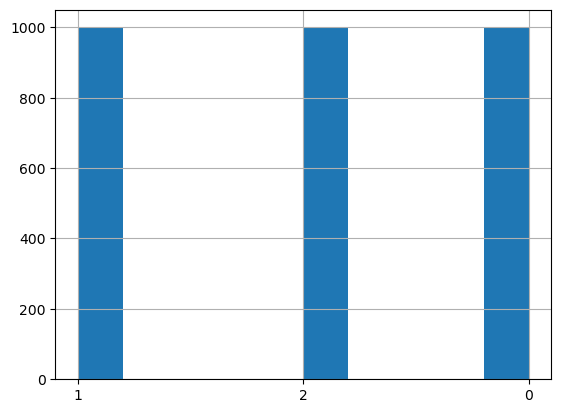

In [33]:
data = pd.concat([data_sql, data_sqli, data_nosql], ignore_index=True)
data['sqli'].hist()

In [34]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(device)

cpu


In [35]:
data.head()

,sql_sentence,sqli
0,SELECT Notes FROM table WHERE Current slogan =...,1
1,SELECT Current series FROM table WHERE Notes =...,1
2,SELECT Format FROM table WHERE State/territory...,1
3,SELECT Text/background colour FROM table WHERE...,1
4,SELECT COUNT Fleet Series (Quantity) FROM tabl...,1


In [36]:
output = model.encode(data['sql_sentence'].tolist()[0])
print(output)

[-3.13125923e-02 -1.17420629e-01 -3.92756201e-02  1.55090526e-01
  5.90119287e-02  1.84879273e-01 -5.43264858e-02 -2.16004774e-02
  1.24925755e-01  9.01637040e-03 -2.87114918e-01 -1.88391190e-02
  3.18993330e-02 -1.12989731e-01  8.32464471e-02 -9.69111174e-02
 -6.36618137e-02 -5.64155951e-02  5.51145226e-02  2.91574508e-01
  4.68800627e-02  7.12015256e-02  2.07112413e-02  5.74590713e-02
 -2.85458595e-01 -3.94663364e-02  4.35461476e-02  4.55318764e-02
 -1.64138693e-02  2.85811216e-01 -9.64787677e-02  7.00302944e-02
  2.18345765e-02 -4.27767355e-03 -1.64760603e-03  7.61290044e-02
  3.39044519e-02  1.97409429e-02  7.62049481e-02 -1.92755423e-02
 -8.59548151e-03 -5.47528677e-02 -6.67706504e-02  7.29717538e-02
  6.02804758e-02 -1.12166274e-02 -1.31138191e-01  1.09080777e-01
 -9.23447683e-02  2.93286368e-02 -8.18381384e-02  1.46888912e-01
 -9.76203233e-02  1.81131102e-02 -9.44178924e-02  6.86698109e-02
 -2.50737704e-02  9.02584568e-02  1.11631736e-01  3.63264196e-02
  3.95307653e-02  6.61467

In [37]:
input = tokenizer(data['sql_sentence'].tolist()[0], return_tensors="pt", padding=True).to(device)
output = model.encode(data['sql_sentence'].tolist()[0])
outputs = torch.from_numpy(output)
outputs = outputs.unsqueeze(0)

for i in range(1, len(data)):
    output = model.encode(data['sql_sentence'].tolist()[i])
    output = torch.from_numpy(output)
    output = output.unsqueeze(0)
    outputs = torch.cat((outputs, output), 0)

In [38]:
outputs.shape

torch.Size([3000, 768])

In [39]:
from sklearn.manifold import TSNE

n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(outputs)
tsne_result.shape

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


(3000, 2)

In [40]:
data['sqli'].values.shape

(3000,)

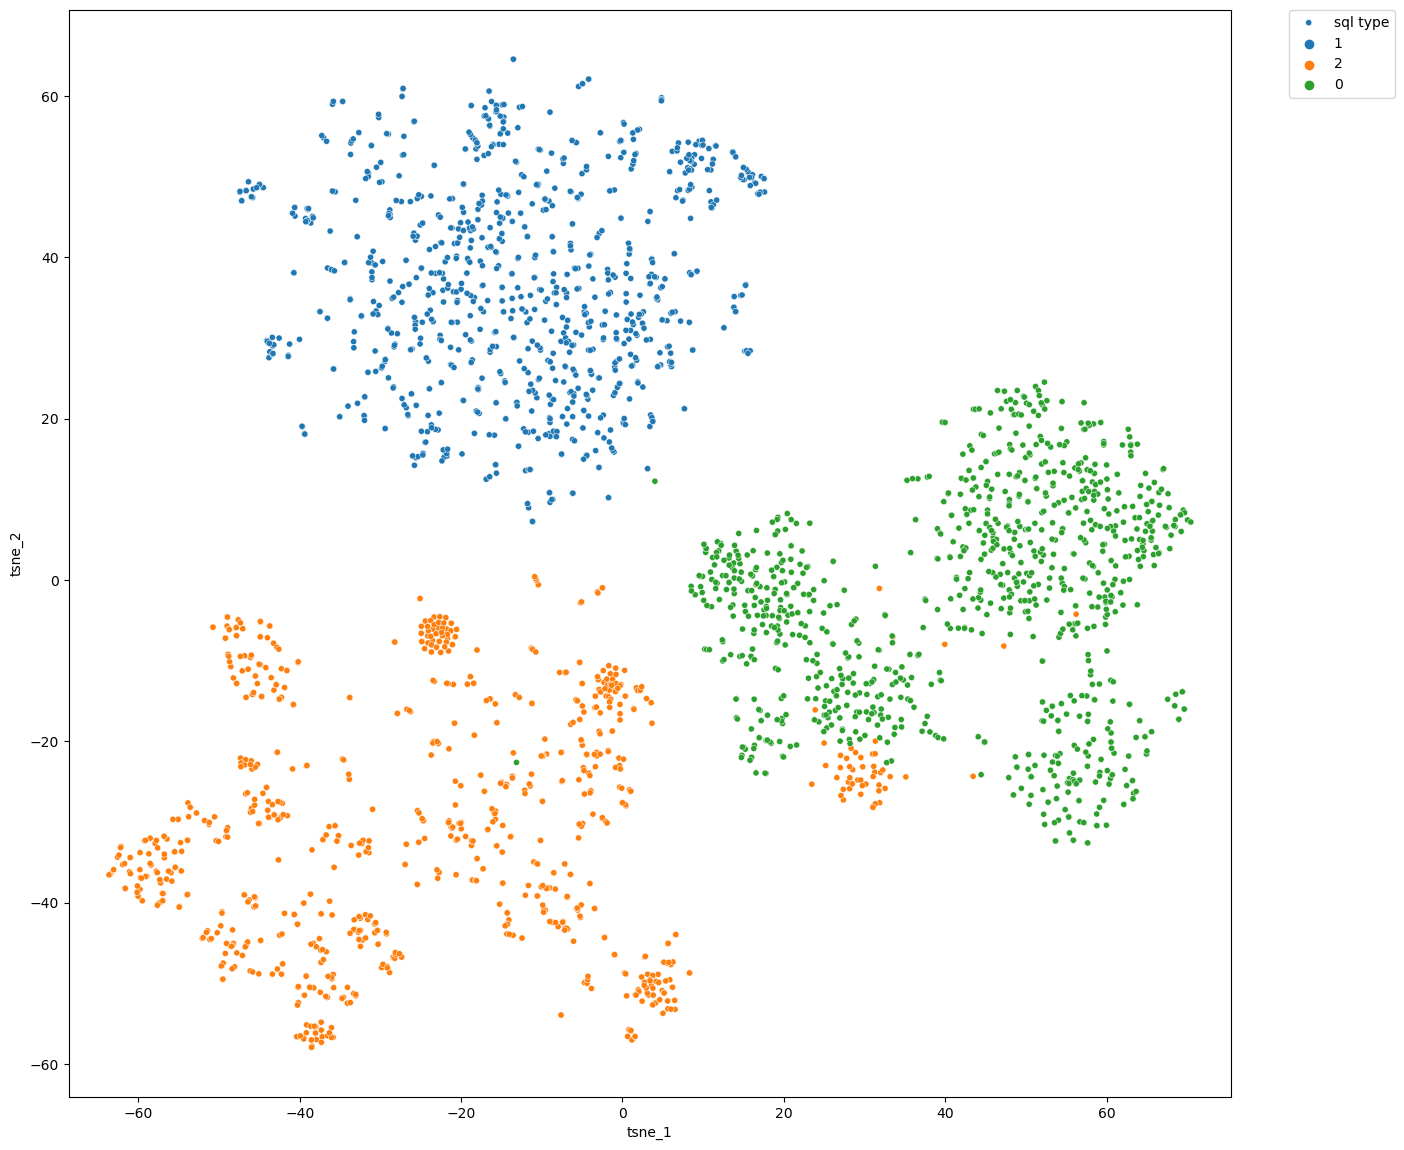

In [41]:
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'sqli': data['sqli'].values})
fig, ax = plt.subplots(1, figsize=(15, 15))

sns.scatterplot(x='tsne_1', y='tsne_2', hue='sqli', label='sql type', data=tsne_result_df, ax=ax,s=20)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)

ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [ ]:
%%capture
pip install tensorboard

In [ ]:
!pip uninstall tensorflow

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()
writer.add_embedding(outputs, metadata=data['is_sql'].tolist())